In [167]:
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

from utils import *

In [168]:
filename = "~/Documents/data/cos513/5G_Traffic_Datasets/Game_Streaming/GeForce_Now/GeForce_Now_2.csv"
local_ip = "10.215.173.1"

In [169]:
df = load_csv(filename)
# stats_src_ip(df)
# stats_dst_ip(df)
dl_pkts = extract_dl_pkt_interval_time(df, local_ip)
ul_pkts = extract_ul_pkt_interval_time(df, local_ip)

In [170]:
dl_pkt_interval = dl_pkts[dl_pkts[:, 0] < 0.05, :]
ul_pkt_interval = ul_pkts[ul_pkts[:, 0] < 0.05, :]

dl_pkt_interval[:, 0] = dl_pkt_interval[:, 0] * 1000
ul_pkt_interval[:, 0] = ul_pkt_interval[:, 0] * 1000

dl_count, dl_bins_count = np.histogram(dl_pkt_interval[:, 0], bins=10000) 
dl_pdf = dl_count / sum(dl_count) 
dl_cdf = np.cumsum(dl_pdf) 

ul_count, ul_bins_count = np.histogram(ul_pkt_interval[:, 0], bins=10000) 
ul_pdf = ul_count / sum(ul_count) 
ul_cdf = np.cumsum(ul_pdf) 

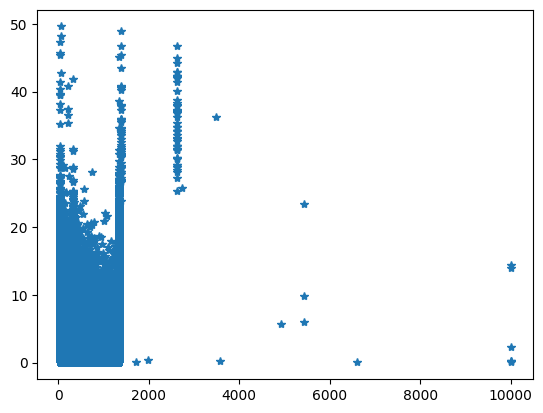

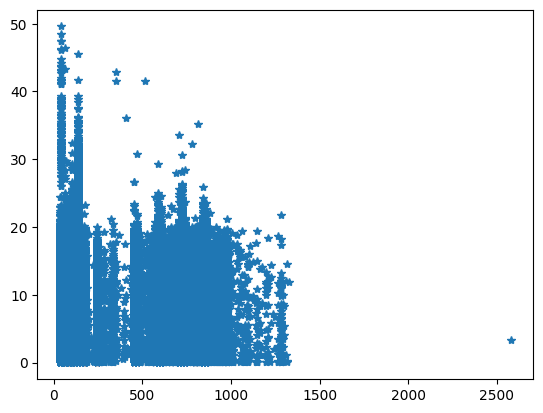

In [171]:
plt.figure()
plt.plot(dl_pkt_interval[:, 2], dl_pkt_interval[:, 0], '*')

plt.figure()
plt.plot(ul_pkt_interval[:, 2], ul_pkt_interval[:, 0], "*")

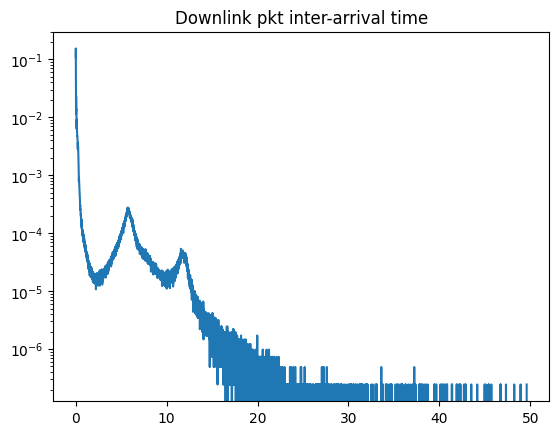

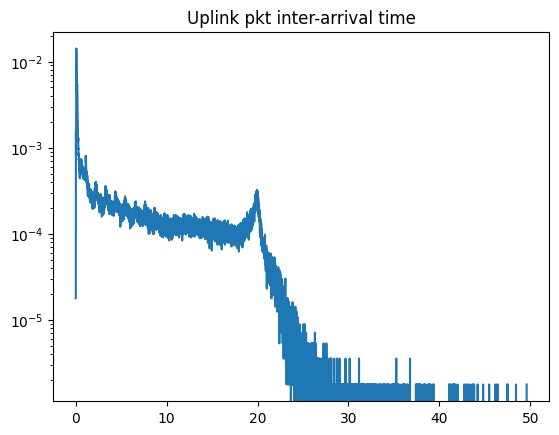

In [174]:
plt.figure()
plt.plot(dl_bins_count[1:], dl_pdf)
plt.yscale("log")
plt.title("Downlink pkt inter-arrival time")

plt.figure()
plt.plot(ul_bins_count[1:], ul_pdf)
plt.yscale("log")
plt.title("Uplink pkt inter-arrival time")

plt.show()

In [7]:
train = torch.tensor(dl_pkt_interval, dtype=torch.float)
pkt_interval, time, pkt_size = train[:, 0], train[:, 1], train[:, 2]

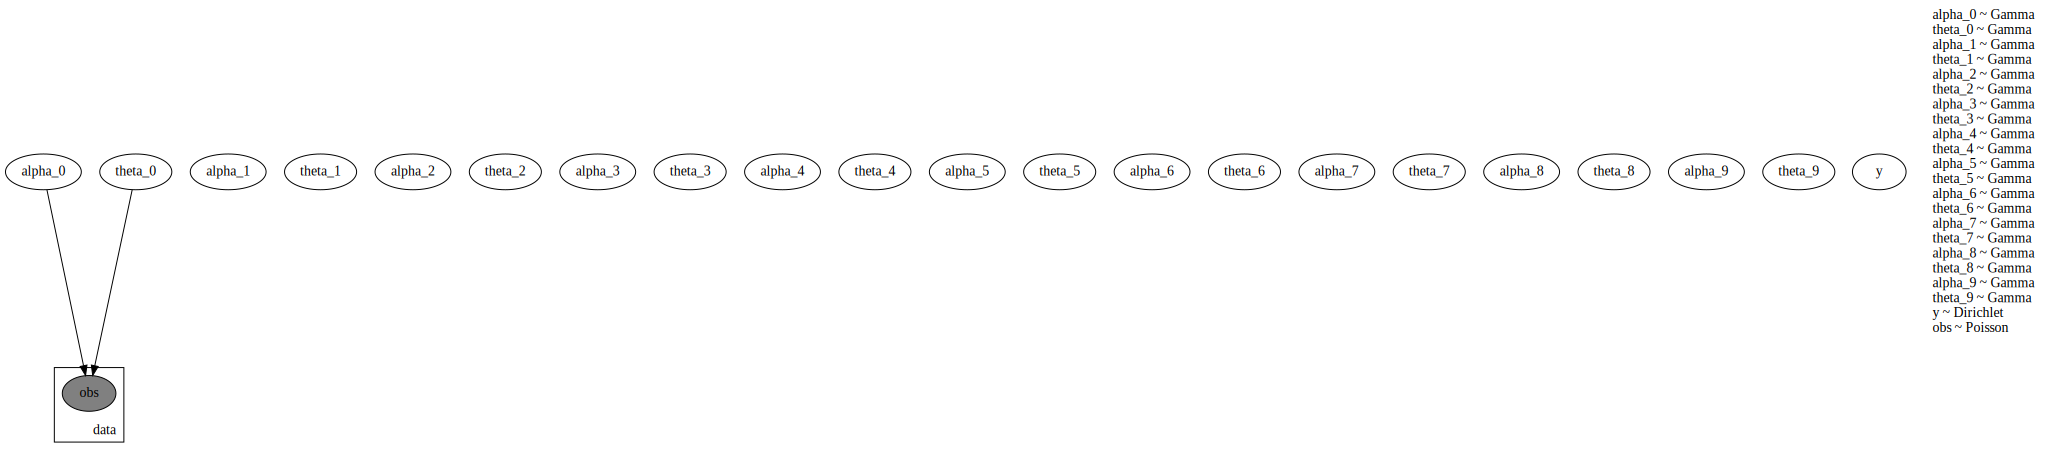

In [162]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

# def categorical_possion()

def model(pkt_size, pkt_interval=None):
    K = 10
    alpha_array = [[] for i in range(K)]
    theta_array = [[] for i in range(K)]

    for i in range(K):
        alpha_array[i] = pyro.sample("alpha_{}".format(i), dist.Gamma(1., 1.))
        theta_array[i] = pyro.sample("theta_{}".format(i), dist.Gamma(1., 1.))

    probs = torch.ones([10]) / 10
    y = pyro.sample("y", dist.Dirichlet(concentration=probs))
    y = int(torch.max(y))
    new_alpha = alpha_array[y] * pkt_size + theta_array[y]

    with pyro.plate("data", len(time)):
        return pyro.sample("obs", dist.Poisson(new_alpha), obs=pkt_interval)

pyro.render_model(model, model_args=(pkt_size, pkt_interval), render_distributions=True)

In [163]:
def custom_guide(pkt_size, pkt_interval=None):
    K = 10
    alpha_alpha_array = [[] for i in range(K)]
    theta_theta_array = [[] for i in range(K)]
    alpha_theta_array = [[] for i in range(K)]
    theta_alpha_array = [[] for i in range(K)]
    alpha_array = [[] for i in range(K)]
    theta_array = [[] for i in range(K)]   

    probs_diri = [[] for i in range(K)]   
    probs = [[] for i in range(K)]     

    for i in range(K):
        alpha_alpha_array[i] = pyro.param("alpha_alpha_{}".format(i), 
                                          lambda: torch.tensor(1.), 
                                          constraint=constraints.positive)
        alpha_theta_array[i] = pyro.param("alpha_theta_{}".format(i), 
                                          lambda: torch.tensor(1.), 
                                          constraint=constraints.positive)
        alpha_array[i] = pyro.sample("alpha_{}".format(i), 
                                     dist.Gamma(alpha_alpha_array[i],
                                                alpha_theta_array[i]))
        
        theta_alpha_array[i] = pyro.param("theta_alpha_{}".format(i), 
                                          lambda: torch.tensor(1.), 
                                          constraint=constraints.positive)
        theta_theta_array[i] = pyro.param("theta_theta_{}".format(i), 
                                          lambda: torch.tensor(1.), 
                                          constraint=constraints.positive)
        theta_array[i] = pyro.sample("theta_{}".format(i), 
                                     dist.Gamma(theta_alpha_array[i],
                                                theta_theta_array[i]))

        probs_diri[i] = pyro.param("probs_mean_{}".format(i), 
                                   lambda: torch.tensor(1.),
                                   constraint=constraints.positive)
    probs_diri = torch.Tensor(probs_diri)
    probs_diri = probs_diri / torch.sum(probs_diri)
    y = int(torch.max(pyro.sample("y", dist.Dirichlet(concentration=probs_diri))))

    return {"alpha_0": alpha_array[0], "theta_0": theta_array[0],
            "alpha_1": alpha_array[1], "theta_1": theta_array[1],
            "alpha_2": alpha_array[2], "theta_2": theta_array[2],
            "alpha_3": alpha_array[3], "theta_3": theta_array[3],
            "alpha_4": alpha_array[4], "theta_4": theta_array[4],
            "alpha_5": alpha_array[5], "theta_5": theta_array[5],
            "alpha_6": alpha_array[6], "theta_6": theta_array[6],
            "alpha_7": alpha_array[7], "theta_7": theta_array[7],
            "alpha_8": alpha_array[8], "theta_8": theta_array[8],
            "alpha_9": alpha_array[9], "theta_9": theta_array[9],
            "y": y
            }

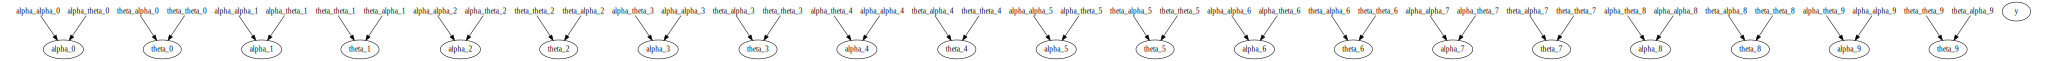

In [164]:
pyro.render_model(custom_guide, model_args=(pkt_size, pkt_interval), render_params=True)

In [165]:
adam = pyro.optim.Adam({"lr": 0.02})
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, custom_guide, adam, elbo)

In [166]:
smoke_test = ('CI' in os.environ)

pyro.clear_param_store()

# These should be reset each training loop.
adam = pyro.optim.Adam({"lr": 0.01})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, custom_guide, adam, elbo)

losses = []
for step in range(10000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(pkt_size, pkt_interval)
    losses.append(loss)
    if step % 100 == 0:
        print("Step: {}, Elbo loss: {}".format(step, loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

ValueError: Error while computing log_prob at site 'obs':
Expected value argument (Tensor of shape (3430486,)) to be within the support (IntegerGreaterThan(lower_bound=0)) of the distribution Poisson(rate: torch.Size([3430486])), but found invalid values:
tensor([ 1.7788, 31.7521,  5.1191,  ...,  0.9310, 26.6950,  0.1380])
Trace Shapes:             
 Param Sites:             
Sample Sites:             
 alpha_0 dist         |   
        value         |   
     log_prob         |   
 theta_0 dist         |   
        value         |   
     log_prob         |   
 alpha_1 dist         |   
        value         |   
     log_prob         |   
 theta_1 dist         |   
        value         |   
     log_prob         |   
 alpha_2 dist         |   
        value         |   
     log_prob         |   
 theta_2 dist         |   
        value         |   
     log_prob         |   
 alpha_3 dist         |   
        value         |   
     log_prob         |   
 theta_3 dist         |   
        value         |   
     log_prob         |   
 alpha_4 dist         |   
        value         |   
     log_prob         |   
 theta_4 dist         |   
        value         |   
     log_prob         |   
 alpha_5 dist         |   
        value         |   
     log_prob         |   
 theta_5 dist         |   
        value         |   
     log_prob         |   
 alpha_6 dist         |   
        value         |   
     log_prob         |   
 theta_6 dist         |   
        value         |   
     log_prob         |   
 alpha_7 dist         |   
        value         |   
     log_prob         |   
 theta_7 dist         |   
        value         |   
     log_prob         |   
 alpha_8 dist         |   
        value         |   
     log_prob         |   
 theta_8 dist         |   
        value         |   
     log_prob         |   
 alpha_9 dist         |   
        value         |   
     log_prob         |   
 theta_9 dist         |   
        value         |   
     log_prob         |   
       y dist         | 10
        value         | 10
     log_prob         |   
     obs dist 3430486 |   
        value 3430486 |   

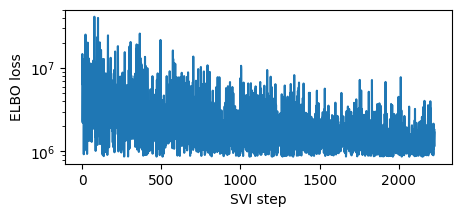

In [ ]:
plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.yscale("log")
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [127]:
with pyro.plate("samples", 800, dim=-1):
    samples = custom_guide(time, pkt_size)

gamma_result = samples["b_r"] + samples["b_ar"]
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_result.detach().cpu().numpy(), kde=True, stat="density", label="samples")
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

KeyError: 'b_r'